In [1]:
import xarray as xr
import os
import pandas as pd
import tqdm
import numpy as np
import time
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from netCDF4 import Dataset
import cmocean

from collections import OrderedDict
from itertools import product
import math
from netCDF4 import Dataset
from cdo import *   # python version
cdo = Cdo()
import matplotlib.pylab as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
%matplotlib inline

In [2]:
# parameters cell
input_paths = ['/p/largedata/hhb19/jstreffi/runtime/awicm-3.1/HIST/outdata/oifs/links/']
input_names = ['HIST']

clim='ERA5'

clim_var='U'
climatology_file = 'qbo_sel_zonmermean.nc'
title='AWI-CM3 equatorial zonal wind evolution'
climatology_path = '/p/project/chhb19/streffing1/obs/era5/netcdf/'
variable = ['U']
variable_clim = 'u'
levels = np.linspace(-20, 20, 11)
levels2=np.linspace(-10,30,12)
labels='m/s'

exps = range(0, 1)
figsize=(6, 3)
dpi = 300
ofile = None

contour_outline_thickness = .2

In [3]:
# Set number of columns, in case of multiple variables
def define_rowscol(input_paths, columns=len(input_paths), reduce=0):
    number_paths = len(input_paths) - reduce
#     columns = columns
    if number_paths < columns:
        ncol = number_paths
    else:
        ncol = columns
    nrows = math.ceil(number_paths / columns)
    return [nrows, ncol]

In [4]:
# Calculate Root Mean Square Deviation (RMSD)
def rmsd(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


In [5]:
# Mean Deviation
def md(predictions, targets):
    return (predictions - targets).mean()


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import Locator
class MinorSymLogLocator(Locator):
    """
    Dynamically find minor tick positions based on the positions of
    major ticks for a symlog scaling.
    """
    def __init__(self, linthresh, nints=10):
        """
        Ticks will be placed between the major ticks.
        The placement is linear for x between -linthresh and linthresh,
        otherwise its logarithmically. nints gives the number of
        intervals that will be bounded by the minor ticks.
        """
        self.linthresh = linthresh
        self.nintervals = nints

    def __call__(self):
        # Return the locations of the ticks
        majorlocs = self.axis.get_majorticklocs()

        if len(majorlocs) == 1:
            return self.raise_if_exceeds(np.array([]))

        # add temporary major tick locs at either end of the current range
        # to fill in minor tick gaps
        dmlower = majorlocs[1] - majorlocs[0]    # major tick difference at lower end
        dmupper = majorlocs[-1] - majorlocs[-2]  # major tick difference at upper end

        # add temporary major tick location at the lower end
        if majorlocs[0] != 0. and ((majorlocs[0] != self.linthresh and dmlower > self.linthresh) or (dmlower == self.linthresh and majorlocs[0] < 0)):
            majorlocs = np.insert(majorlocs, 0, majorlocs[0]*10.)
        else:
            majorlocs = np.insert(majorlocs, 0, majorlocs[0]-self.linthresh)

        # add temporary major tick location at the upper end
        if majorlocs[-1] != 0. and ((np.abs(majorlocs[-1]) != self.linthresh and dmupper > self.linthresh) or (dmupper == self.linthresh and majorlocs[-1] > 0)):
            majorlocs = np.append(majorlocs, majorlocs[-1]*10.)
        else:
            majorlocs = np.append(majorlocs, majorlocs[-1]+self.linthresh)

        # iterate through minor locs
        minorlocs = []

        # handle the lowest part
        for i in xrange(1, len(majorlocs)):
            majorstep = majorlocs[i] - majorlocs[i-1]
            if abs(majorlocs[i-1] + majorstep/2) < self.linthresh:
                ndivs = self.nintervals
            else:
                ndivs = self.nintervals - 1.

            minorstep = majorstep / ndivs
            locs = np.arange(majorlocs[i-1], majorlocs[i], minorstep)[1:]
            minorlocs.extend(locs)

        return self.raise_if_exceeds(np.array(minorlocs))

    def tick_values(self, vmin, vmax):
        raise NotImplementedError('Cannot get tick locations for a '
                          '%s type.' % type(self))


In [7]:
# Load model data

data = OrderedDict()
for exp_path, exp_name  in zip(input_paths, input_names):
    data[exp_name] = {}
    for v in variable:
        paths = []
        data[exp_name][v] = []
        path = exp_path+'qbo_sel_zonmermean.nc'

        data[exp_name][v].append(cdo.copy(input=str(path),returnArray=v))

(292, 19)


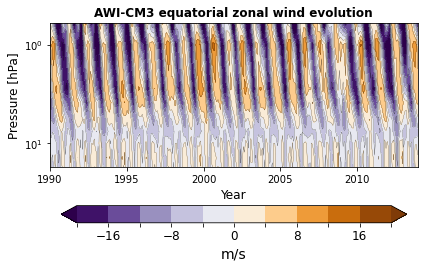

In [8]:
data_model = OrderedDict()
data_model_mean = OrderedDict()


for exp_name in input_names:
    data_model[exp_name] = np.squeeze(data[exp_name][clim_var]) 
    data_model_mean[exp_name] = data_model[exp_name]

print(np.shape(data_model_mean[exp_name]))


nrows, ncol = define_rowscol(input_paths)
fig, axes = plt.subplots(nrows=nrows, ncols=ncol, figsize=figsize)
if isinstance(axes, np.ndarray):
    axes = axes.flatten()
else:
    axes = [axes]
i = 0

x = [100,92.5,85,70,60,50,40,30,25,20,15,10,7,5,3,2,1,0.5,0.1]
x=np.asarray(x)
time = np.arange(1990, 2014, 0.0823)


for key in input_names:

    axes[i]=plt.subplot(nrows,ncol,i+1)
    imf=plt.contourf(time,x, data_model_mean[exp_name].T, cmap=plt.cm.PuOr_r, 
                     levels=levels, extend='both',
                     zorder=1)
    line_colors = ['black' for l in imf.levels]
    imc=plt.contour(time,x, data_model_mean[exp_name].T, colors=line_colors, 
                    levels=levels, linewidths=contour_outline_thickness,
                    zorder=2)

    axes[i].set_ylabel('Pressure [hPa]',fontsize=12)
    axes[i].set_xlabel('Year',fontsize=12)
    
    axes[i].set_title(title,fontweight="bold")
    axes[i].set_yscale('symlog')
    axes[i].invert_yaxis()
    axes[i].set(ylim=[20, 0.5])

    plt.tight_layout() 

    i = i+1
    
    cbar_ax_abs = fig.add_axes([0.15, -0.05, 0.8, 0.08])
    cbar_ax_abs.tick_params(labelsize=12)
    cb = fig.colorbar(imf, cax=cbar_ax_abs, orientation='horizontal',ticks=levels)
    cb.set_label(label=labels, size='14')
    cb.ax.tick_params(labelsize='12')
    #plt.text(5, 168, r'rmsd='+str(round(rmsdval,3)))
    #plt.text(-7.5, 168, r'bias='+str(round(mdval,3)))
    
for label in cb.ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

    
ofile=variable[0]+'AWI-CM3-qbo.png'
    
if ofile is not None:
    plt.savefig(ofile, dpi=dpi,bbox_inches='tight')
    os.system(f'convert {ofile} -trim {ofile}_trimmed.png')
    os.system(f'mv {ofile}_trimmed.png {ofile}')

In [9]:
# Load NCEP2 reanalysis data

ERA5_CRF = cdo.copy(input=str(climatology_path)+'/'+str(climatology_file),returnArray=clim_var)


In [10]:
np.shape(ERA5_CRF)

(312, 19, 1, 1)

(312, 19)


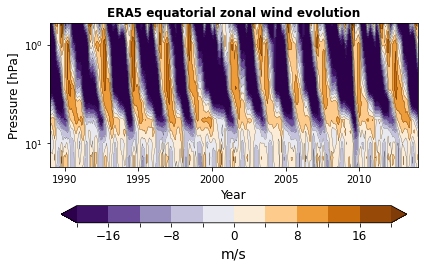

In [11]:
data_model = OrderedDict()
data_model_mean = OrderedDict()

title2='ERA5 equatorial zonal wind evolution'


for exp_name in input_names:
    data_model[exp_name] = np.squeeze(ERA5_CRF) 
    data_model_mean[exp_name] = np.fliplr(data_model[exp_name])

print(np.shape(data_model_mean[exp_name]))


nrows, ncol = define_rowscol(input_paths)
fig, axes = plt.subplots(nrows=nrows, ncols=ncol, figsize=figsize)
if isinstance(axes, np.ndarray):
    axes = axes.flatten()
else:
    axes = [axes]
i = 0

x = [100,92.5,85,70,60,50,40,30,25,20,15,10,7,5,3,2,1,0.5,0.1]
x=np.asarray(x)
time = np.arange(1989, 2014, 0.0803)


for key in input_names:

    axes[i]=plt.subplot(nrows,ncol,i+1)
    imf=plt.contourf(time,x, data_model_mean[exp_name].T, cmap=plt.cm.PuOr_r, 
                     levels=levels, extend='both',
                     zorder=1)
    line_colors = ['black' for l in imf.levels]
    imc=plt.contour(time,x, data_model_mean[exp_name].T, colors=line_colors, 
                    levels=levels, linewidths=contour_outline_thickness,
                    zorder=2)

    axes[i].set_ylabel('Pressure [hPa]',fontsize=12)
    axes[i].set_xlabel('Year',fontsize=12)
    
    axes[i].set_title(title2,fontweight="bold")
    axes[i].set_yscale('symlog')
    axes[i].invert_yaxis()
    axes[i].set(ylim=[20, 0.5])

    plt.tight_layout() 

    i = i+1
    
    cbar_ax_abs = fig.add_axes([0.15, -0.05, 0.8, 0.08])
    cbar_ax_abs.tick_params(labelsize=12)
    cb = fig.colorbar(imf, cax=cbar_ax_abs, orientation='horizontal',ticks=levels)
    cb.set_label(label=labels, size='14')
    cb.ax.tick_params(labelsize='12')
    #plt.text(5, 168, r'rmsd='+str(round(rmsdval,3)))
    #plt.text(-7.5, 168, r'bias='+str(round(mdval,3)))
    
for label in cb.ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

    
ofile=variable[0]+'ERA5-qbo.png'
    
if ofile is not None:
    plt.savefig(ofile, dpi=dpi,bbox_inches='tight')
    os.system(f'convert {ofile} -trim {ofile}_trimmed.png')
    os.system(f'mv {ofile}_trimmed.png {ofile}')